原文：https://mp.weixin.qq.com/s/SylxdbdcjaqGyb9F9lcJyw   
github项目：https://github.com/sksujan58/Multivariate-time-series-forecasting-using-LSTM

LSTM基本上是一个循环神经网络，能够处理长期依赖关系。

假设你在看一部电影。所以当电影中发生任何情况时，你都已经知道之前发生了什么，并且可以理解因为过去发生的事情所以才会有新的情况发生。RNN也是以同样的方式工作，它们记住过去的信息并使用它来处理当前的输入。RNN的问题是，由于渐变消失，它们不能记住长期依赖关系。因此为了避免长期依赖问题设计了lstm。

现在我们讨论了时间序列预测和LSTM理论部分。让我们开始编码。  

# 导入进行预测所需的库

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# 加载数据

In [15]:
df = pd.read_csv('../dataset/000001.SZ-None.csv',parse_dates=['trade_date'],index_col=[2])
df2 = pd.read_csv('../dataset/000001.SZ-qfq.csv',parse_dates=['trade_date'],index_col=[2])
df['Adj Close']=df2['close']
df = df.rename(columns={"open":"Open","high":"High","low":"Low","close":"Close"})
df=df[["Open","High","Low","Close","Adj Close"]]
df.dropna(axis=0,inplace=True)
df

,Open,High,Low,Close,Adj Close
trade_date,,,,,
2021-09-29,17.86,18.44,17.71,18.15,18.1500
2021-09-28,17.47,18.17,17.45,17.97,17.9700
2021-09-27,17.21,17.68,17.06,17.57,17.5700
2021-09-24,17.60,17.68,17.34,17.35,17.3500
2021-09-23,18.10,18.32,17.65,17.68,17.6800
...,...,...,...,...,...
2001-03-06,15.05,15.12,14.83,15.10,3.2864
2001-03-05,15.11,15.41,15.01,15.05,3.2756
2001-03-02,14.42,15.28,14.41,15.05,3.2756


In [17]:
df.sort_index(axis=0,inplace=True)
df

,Open,High,Low,Close,Adj Close
trade_date,,,,,
2001-02-28,14.20,14.20,14.05,14.09,3.0666
2001-03-01,14.20,14.50,14.10,14.30,3.1123
2001-03-02,14.42,15.28,14.41,15.05,3.2756
2001-03-05,15.11,15.41,15.01,15.05,3.2756
2001-03-06,15.05,15.12,14.83,15.10,3.2864
...,...,...,...,...,...
2021-09-23,18.10,18.32,17.65,17.68,17.6800
2021-09-24,17.60,17.68,17.34,17.35,17.3500
2021-09-27,17.21,17.68,17.06,17.57,17.5700


In [21]:
test_split = round(len(df) * 0.20)
df_for_training = df[:-test_split]
df_for_testing = df[-test_split:]
print(df_for_training.shape)
print(df_for_testing.shape)

(3872, 5)
(968, 5)


# MinMaxScaler缩放数据

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled = scaler.transform(df_for_testing)
df_for_training_scaled

array([[0.21680152, 0.20502857, 0.21448999, 0.20931315, 0.15864403],
       [0.21680152, 0.21188571, 0.2156816 , 0.21420256, 0.16240696],
       [0.22203713, 0.22971429, 0.22306959, 0.23166473, 0.17585304],
       ...,
       [0.15421228, 0.14651429, 0.14799809, 0.1443539 , 0.78992655],
       [0.14850071, 0.14331429, 0.14966635, 0.14831199, 0.80322443],
       [0.15207044, 0.14514286, 0.14990467, 0.14970896, 0.80791779]])

In [33]:
def createXY(dataset,n_past):
  dataX = []
  dataY = []
  for i in range(n_past, len(dataset)):
          dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
          dataY.append(dataset[i,0])
  return np.array(dataX),np.array(dataY)

trainX,trainY=createXY(df_for_training_scaled,30)
testX,testY=createXY(df_for_testing_scaled,30)

In [36]:
testX.shape

(938, 30, 5)

# 建立模型

In [37]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50, return_sequences=True, input_shape=(30, 5)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    grid_model.compile(loss='mse', optimizer=optimizer)
    return grid_model


grid_model = KerasRegressor(build_fn=build_model,
                            verbose=1,
                            validation_data=(testX, testY))

parameters = {
    'batch_size': [16, 20],
    'epochs': [8, 10],
    'optimizer': ['adam', 'Adadelta']
}

grid_search = GridSearchCV(estimator=grid_model, param_grid=parameters, cv=2)

D:\ProgramData\anaconda3\envs\ml37\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  del sys.path[0]


In [38]:
grid_search = grid_search.fit(trainX,trainY)

Epoch 1/8
121/121 [==============================] - 5s 19ms/step - loss: 0.0023 - val_loss: 8.1924e-04
Epoch 2/8
121/121 [==============================] - 2s 14ms/step - loss: 7.5474e-04 - val_loss: 8.3685e-04
Epoch 3/8
121/121 [==============================] - 2s 14ms/step - loss: 6.6597e-04 - val_loss: 3.5524e-04
Epoch 4/8
121/121 [==============================] - 2s 14ms/step - loss: 6.1613e-04 - val_loss: 7.2881e-04
Epoch 5/8
121/121 [==============================] - 2s 15ms/step - loss: 5.9756e-04 - val_loss: 0.0014
Epoch 6/8
121/121 [==============================] - 2s 15ms/step - loss: 5.5965e-04 - val_loss: 6.6206e-04
Epoch 7/8
121/121 [==============================] - 2s 14ms/step - loss: 5.3722e-04 - val_loss: 1.5029e-04
Epoch 8/8
121/121 [==============================] - 0s 4ms/step - loss: 6.3713e-04
Epoch 1/8
121/121 [==============================] - 5s 19ms/step - loss: 0.0037 - val_loss: 0.0089
Epoch 2/8
121/121 [==============================] - 2s 15ms/step - 

97/97 [==============================] - 2s 16ms/step - loss: 6.8004e-04 - val_loss: 1.8379e-04
Epoch 4/8
97/97 [==============================] - 2s 16ms/step - loss: 5.6874e-04 - val_loss: 1.6677e-04
Epoch 5/8
97/97 [==============================] - 2s 16ms/step - loss: 5.7716e-04 - val_loss: 2.9564e-04
Epoch 6/8
97/97 [==============================] - 2s 17ms/step - loss: 4.7199e-04 - val_loss: 3.9043e-04
Epoch 7/8
97/97 [==============================] - 2s 16ms/step - loss: 4.8333e-04 - val_loss: 2.0022e-04
Epoch 8/8
97/97 [==============================] - 0s 4ms/step - loss: 6.4942e-04
Epoch 1/8
97/97 [==============================] - 4s 21ms/step - loss: 0.0061 - val_loss: 0.0127
Epoch 2/8
97/97 [==============================] - 2s 16ms/step - loss: 0.0017 - val_loss: 0.0066
Epoch 3/8
97/97 [==============================] - 2s 16ms/step - loss: 0.0013 - val_loss: 0.0090
Epoch 4/8
97/97 [==============================] - 2s 16ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 

193/193 [==============================] - 3s 14ms/step - loss: 7.3961e-04 - val_loss: 5.0900e-04
Epoch 7/10
193/193 [==============================] - 3s 14ms/step - loss: 6.4363e-04 - val_loss: 1.8465e-04
Epoch 8/10
193/193 [==============================] - 3s 14ms/step - loss: 5.3409e-04 - val_loss: 1.1921e-04
Epoch 9/10
193/193 [==============================] - 3s 14ms/step - loss: 5.5556e-04 - val_loss: 1.7351e-04
Epoch 10/10
193/193 [==============================] - 3s 15ms/step - loss: 5.4185e-04 - val_loss: 4.9756e-04


In [39]:
grid_search.best_params_

{'batch_size': 20, 'epochs': 10, 'optimizer': 'adam'}

In [40]:
my_model=grid_search.best_estimator_.model

# 预测

In [41]:
prediction = my_model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-", prediction.shape)

prediction
 [[0.20076765]
 [0.20708121]
 [0.20864563]
 [0.20558423]
 [0.1994719 ]
 [0.1942609 ]
 [0.18872297]
 [0.18251449]
 [0.17828685]
 [0.1762369 ]
 [0.17432518]
 [0.17199217]
 [0.17081413]
 [0.17255928]
 [0.1738471 ]
 [0.17421351]
 [0.1741539 ]
 [0.17213163]
 [0.1698903 ]
 [0.17041811]
 [0.17249282]
 [0.1759422 ]
 [0.1795105 ]
 [0.18138461]
 [0.18299502]
 [0.18328962]
 [0.1818994 ]
 [0.18050942]
 [0.1816957 ]
 [0.18238318]
 [0.18142223]
 [0.18017784]
 [0.17770141]
 [0.17555626]
 [0.17564157]
 [0.1771593 ]
 [0.17963238]
 [0.18477699]
 [0.19078039]
 [0.19661556]
 [0.20234814]
 [0.2080973 ]
 [0.21031411]
 [0.21091908]
 [0.21137781]
 [0.20845197]
 [0.20432138]
 [0.19909585]
 [0.19369262]
 [0.19098121]
 [0.19088286]
 [0.19122817]
 [0.19383854]
 [0.19519371]
 [0.19118762]
 [0.18214047]
 [0.16796234]
 [0.15554228]
 [0.14849257]
 [0.14513353]
 [0.14703104]
 [0.15182033]
 [0.15692705]
 [0.15931776]
 [0.15808505]
 [0.15563256]
 [0.15285526]
 [0.15040594]
 [0.14940771]
 [0.14985828]
 [0.1504

In [42]:
scaler.inverse_transform(prediction)

ValueError: non-broadcastable output operand with shape (938,1) doesn't match the broadcast shape (938,5)

In [45]:
prediction_copies_array = np.repeat(prediction,5, axis=-1)

In [46]:
prediction_copies_array.shape

(938, 5)

In [47]:
prediction_copies_array

array([[0.20076765, 0.20076765, 0.20076765, 0.20076765, 0.20076765],
       [0.20708121, 0.20708121, 0.20708121, 0.20708121, 0.20708121],
       [0.20864563, 0.20864563, 0.20864563, 0.20864563, 0.20864563],
       ...,
       [0.27774206, 0.27774206, 0.27774206, 0.27774206, 0.27774206],
       [0.27137196, 0.27137196, 0.27137196, 0.27137196, 0.27137196],
       [0.2707103 , 0.2707103 , 0.2707103 , 0.2707103 , 0.2707103 ]],
      dtype=float32)

In [62]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),5)))[:,0]
pred

array([13.5262575, 13.7915535, 13.857289 , 13.728649 , 13.47181  ,
       13.252843 , 13.020139 , 12.759258 , 12.581614 , 12.495474 ,
       12.415145 , 12.317111 , 12.26761  , 12.340941 , 12.395056 ,
       12.410452 , 12.407947 , 12.322971 , 12.228791 , 12.250969 ,
       12.338149 , 12.483091 , 12.633031 , 12.7117815, 12.77945  ,
       12.79183  , 12.733413 , 12.675006 , 12.7248535, 12.753741 ,
       12.713362 , 12.661073 , 12.5570135, 12.466874 , 12.470458 ,
       12.534234 , 12.638153 , 12.854329 , 13.106592 , 13.351787 ,
       13.592669 , 13.834249 , 13.9274   , 13.95282  , 13.972096 ,
       13.849153 , 13.675585 , 13.456007 , 13.228964 , 13.11503  ,
       13.110898 , 13.125408 , 13.235095 , 13.29204  , 13.123704 ,
       12.743543 , 12.147778 , 11.625887 , 11.329658 , 11.188511 ,
       11.268244 , 11.46949  , 11.684074 , 11.784533 , 11.732734 ,
       11.62968  , 11.512979 , 11.410058 , 11.368112 , 11.387046 ,
       11.4124   , 11.440366 , 11.452813 , 11.458301 , 11.4240

In [63]:
original_copies_array = np.repeat(testY,5, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),5)))[:,0]

In [66]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [13.5262575 13.7915535 13.857289  13.728649  13.47181   13.252843
 13.020139  12.759258  12.581614  12.495474  12.415145  12.317111
 12.26761   12.340941  12.395056  12.410452  12.407947  12.322971
 12.228791  12.250969  12.338149  12.483091  12.633031  12.7117815
 12.77945   12.79183   12.733413  12.675006  12.7248535 12.753741
 12.713362  12.661073  12.5570135 12.466874  12.470458  12.534234
 12.638153  12.854329  13.106592  13.351787  13.592669  13.834249
 13.9274    13.95282   13.972096  13.849153  13.675585  13.456007
 13.228964  13.11503   13.110898  13.125408  13.235095  13.29204
 13.123704  12.743543  12.147778  11.625887  11.329658  11.188511
 11.268244  11.46949   11.684074  11.784533  11.732734  11.62968
 11.512979  11.410058  11.368112  11.387046  11.4124    11.440366
 11.452813  11.458301  11.424046  11.334677  11.238032  11.181929
 11.162944  11.201904  11.2016735 11.053834  10.828562  10.633264
 10.478477  10.389135  10.344972  10.29157   10.197868  10.179

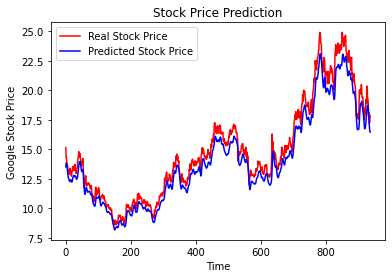

In [67]:
plt.plot(original, color = 'red', label = 'Real Stock Price')
plt.plot(pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

# 预测未来值

In [68]:
df_30_days_past=df.iloc[-30:,:]
df_30_days_past.tail()

,Open,High,Low,Close,Adj Close
trade_date,,,,,
2021-09-23,18.10,18.32,17.65,17.68,17.68
2021-09-24,17.60,17.68,17.34,17.35,17.35
2021-09-27,17.21,17.68,17.06,17.57,17.57
2021-09-28,17.47,18.17,17.45,17.97,17.97
2021-09-29,17.86,18.44,17.71,18.15,18.15


In [71]:
df_30_days_future = pd.read_csv('../dataset/000001.SZ-None-2.csv',parse_dates=['trade_date'],index_col=[2])
df_30_days_future2 = pd.read_csv('../dataset/000001.SZ-qfq-2.csv',parse_dates=['trade_date'],index_col=[2])
df_30_days_future['Adj Close']=df_30_days_future2['close']
df_30_days_future = df_30_days_future.rename(columns={"open":"Open","high":"High","low":"Low","close":"Close"})
df_30_days_future=df_30_days_future[["Open","High","Low","Close","Adj Close"]]
df_30_days_future.dropna(axis=0,inplace=True)
df_30_days_future.sort_index(axis=0,inplace=True)
df_30_days_future

,Open,High,Low,Close,Adj Close
trade_date,,,,,
2021-09-30,18.09,18.20,17.71,17.93,17.93
2021-10-08,18.17,18.89,18.02,18.64,18.64
2021-10-11,19.00,19.74,19.00,19.40,19.40
2021-10-12,19.30,19.71,19.20,19.35,19.35
2021-10-13,19.30,19.91,19.17,19.58,19.58
2021-10-14,19.59,19.92,18.89,19.21,19.21
2021-10-15,19.00,19.90,19.00,19.66,19.66
2021-10-18,19.45,19.55,19.10,19.29,19.29
2021-10-19,19.15,19.68,19.15,19.57,19.57


In [73]:
df_30_days_future.drop(columns=['Open'],inplace=True)
df_30_days_future

,High,Low,Close,Adj Close
trade_date,,,,
2021-09-30,18.20,17.71,17.93,17.93
2021-10-08,18.89,18.02,18.64,18.64
2021-10-11,19.74,19.00,19.40,19.40
2021-10-12,19.71,19.20,19.35,19.35
2021-10-13,19.91,19.17,19.58,19.58
2021-10-14,19.92,18.89,19.21,19.21
2021-10-15,19.90,19.00,19.66,19.66
2021-10-18,19.55,19.10,19.29,19.29
2021-10-19,19.68,19.15,19.57,19.57


In [75]:
df_30_days_future["Open"] = 0
df_30_days_future = df_30_days_future[[
    "Open", "High", "Low", "Close", "Adj Close"
]]
old_scaled_array = scaler.transform(df_30_days_past)
new_scaled_array = scaler.transform(df_30_days_future)
new_scaled_df = pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:, 0] = np.nan
full_df = pd.concat([pd.DataFrame(old_scaled_array),
                     new_scaled_df]).reset_index().drop(["index"], axis=1)

,0,1,2,3,4
0,0.351261,0.342629,0.346997,0.339232,1.525764
1,0.346978,0.365029,0.345567,0.361350,1.603987
2,0.366254,0.351771,0.356768,0.354831,1.580932
3,0.354117,0.339200,0.325310,0.333411,1.505179
4,0.342932,0.338743,0.335081,0.330617,1.495298
5,0.339362,0.336914,0.337464,0.332014,1.500239
6,0.341028,0.325486,0.331268,0.327357,1.483771
7,0.335792,0.320686,0.318398,0.311059,1.426133
8,0.320562,0.312000,0.316015,0.309430,1.420369
9,0.312232,0.298514,0.297903,0.293830,1.365202


In [76]:
full_df.shape

(55, 5)

In [78]:
full_df.tail()

,0,1,2,3,4
50,NaN,0.294171,0.303861,0.297322,1.377553
51,NaN,0.291886,0.298379,0.291967,1.358614
52,NaN,0.287543,0.293375,0.286845,1.340500
53,NaN,0.283886,0.290991,0.289406,1.349557
54,NaN,0.279771,0.288608,0.286380,1.338853


In [79]:
full_df_scaled_array=full_df.values

In [80]:
full_df_scaled_array.shape

(55, 5)

In [86]:
all_data=[]
time_step=30
for i in range(time_step,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(full_df_scaled_array[i-time_step:i,0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=my_model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction

In [90]:
all_data

[array([[0.2739123]], dtype=float32),
 array([[0.27523094]], dtype=float32),
 array([[0.27955592]], dtype=float32),
 array([[0.28873324]], dtype=float32),
 array([[0.2970574]], dtype=float32),
 array([[0.3040335]], dtype=float32),
 array([[0.3070683]], dtype=float32),
 array([[0.3096056]], dtype=float32),
 array([[0.30937743]], dtype=float32),
 array([[0.3093924]], dtype=float32),
 array([[0.30838236]], dtype=float32),
 array([[0.31020862]], dtype=float32),
 array([[0.3138842]], dtype=float32),
 array([[0.31633395]], dtype=float32),
 array([[0.3184592]], dtype=float32),
 array([[0.31865054]], dtype=float32),
 array([[0.31687486]], dtype=float32),
 array([[0.31387168]], dtype=float32),
 array([[0.31043074]], dtype=float32),
 array([[0.30209094]], dtype=float32),
 array([[0.29229444]], dtype=float32),
 array([[0.28371993]], dtype=float32),
 array([[0.27655616]], dtype=float32),
 array([[0.2705684]], dtype=float32),
 array([[0.26663104]], dtype=float32)]

In [97]:
new_array = np.array(all_data)
new_array = new_array.reshape(-1, 1)
prediction_copies_array = np.repeat(new_array, 5, axis=-1)
y_pred_future_30_days = scaler.inverse_transform(
    np.reshape(prediction_copies_array, (len(new_array), 5)))[:, 0]

In [98]:
y_pred_future_30_days

array([16.599794, 16.655205, 16.836939, 17.22257 , 17.572351, 17.865486,
       17.99301 , 18.099627, 18.09004 , 18.090668, 18.048227, 18.124966,
       18.279413, 18.382353, 18.471657, 18.479696, 18.40508 , 18.278889,
       18.1343  , 17.783861, 17.372211, 17.011911, 16.71089 , 16.459284,
       16.293837], dtype=float32)

# 预测结果

In [109]:
original_future_30 = pd.read_csv('../dataset/000001.SZ-None-2.csv',parse_dates=['trade_date'],index_col=[2])[['open']]
original_future_30.sort_index(inplace=True)
original_future_30 = original_future_30['open'].values
original_future_30

array([18.09, 18.17, 19.  , 19.3 , 19.3 , 19.59, 19.  , 19.45, 19.15,
       19.75, 19.52, 20.16, 19.71, 20.06, 20.  , 19.8 , 19.63, 19.33,
       19.37, 18.1 , 18.08, 17.85, 17.62, 17.48, 17.46])

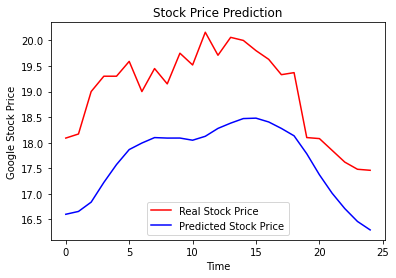

In [110]:
plt.plot(original_future_30, color = 'red', label = 'Real Stock Price')
plt.plot(y_pred_future_30_days, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

# save model

In [100]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

my_model.save('../dataset/Model_future_value.h5')
print('Model Saved!')

Model Saved!


In [101]:
scaler

MinMaxScaler()

In [102]:
import pickle
scalerfile = '../dataset/scaler_model_future_value.pkl'
pickle.dump(scaler, open(scalerfile, 'wb'))